In [41]:
import numpy as np
import matplotlib.pyplot as plt

In [42]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [43]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

ibmqfactory.load_account:WARNING:2021-07-27 14:30:18,551: Credentials are already in use. The existing account in the session will be replaced.


In [44]:
from qiskit import pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor

In [45]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer

In [46]:
backend = provider.get_backend('ibmq_armonk')
# backend = PulseSimulator()
# backend = provider.get_backend('ibmq_bogota')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"
dt = backend_config.dt

backend_defaults = backend.defaults()
meas_map = np.array(backend_config.meas_map[0])

In [47]:
backend_defaults.qubit_freq_est

[4971648972.721859]

In [48]:
# number of shots for our experiments
NUM_SHOTS = 1024
SIGMA = 75e-9
TRUNC = 8
MAXFREQS = 75
MAXDRIVE = 0.1
SAMPLE = 16
SCALE = 1e-14

In [49]:
qubit=0
default_qubit_freq = backend_defaults.qubit_freq_est[qubit]
# Find out which measurement map index is needed for this qubit
meas_map_idx = np.where(qubit==meas_map)[0][0]
# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qubit)

In [50]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [51]:
# Drive pulse parameters (us = microseconds)
drive_sigma = SAMPLE * round(SIGMA/ SAMPLE/ dt)       # The width of the gaussian in units of dt
drive_samples = TRUNC * drive_sigma   # The truncating parameter in units of dt
drive_power = MAXDRIVE

# We will sweep 40 MHz around the estimated frequency, with 75 frequencies
span = default_qubit_freq/200
freqs = default_qubit_freq + np.linspace(-span, span, MAXFREQS)

# Define the drive pulse
ground_sweep_drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                                  sigma=drive_sigma,
                                                  amp=drive_power,
                                                  name='ground_sweep_drive_pulse')

# Create the base schedule
schedule = pulse.Schedule(name='Frequency sweep starting from ground state.')

schedule |= pulse.Play(ground_sweep_drive_pulse, drive_chan)
schedule |= measure << schedule.duration

# define frequencies for the sweep
schedule_freqs = [{drive_chan: freq} for freq in freqs]

# assemble the program
# Note: we only require a single schedule since each does the same thing;
# for each schedule, the LO frequency that mixes down the drive changes
# this enables our frequency sweep
ground_freq_sweep_program = assemble(schedule,
                                     backend=backend, 
                                     meas_level=1,
                                     meas_return='avg',
                                     shots=NUM_SHOTS,
                                     schedule_los=schedule_freqs)

ground_freq_sweep_job = backend.run(ground_freq_sweep_program)
job_monitor(ground_freq_sweep_job)
job_results = ground_freq_sweep_job.result(timeout=120)
# ground_freq_sweep_data

/home/abarthe/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.


Job Status: job has successfully run


In [52]:
result_data = [job_results.get_memory(i)[qubit]*SCALE for i in range(MAXFREQS)]

In [53]:
def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [54]:
(ground_sweep_fit_params, ground_sweep_y_fit) = fit_function(freqs,
                                   result_data, 
                                   lambda x, q_freq, A, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                   [default_qubit_freq, 10, 0.1*1e9, 3*1e9] # initial parameters for curve_fit 4.975
                                   )

/home/abarthe/miniconda3/envs/CDLwk3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


/home/abarthe/miniconda3/envs/CDLwk3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


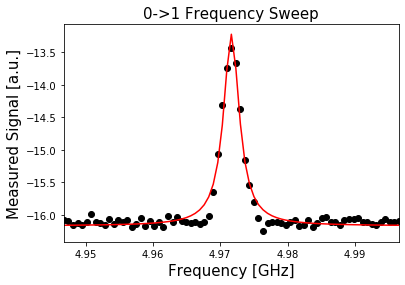

In [55]:
# Note: we are only plotting the real part of the signal
plt.scatter(freqs/1e9, result_data, color='black')
plt.plot(freqs/1e9, ground_sweep_y_fit, color='red')
plt.xlim([min(freqs/1e9), max(freqs/1e9)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("0->1 Frequency Sweep", fontsize=15)
plt.show()

In [56]:
calib_qubit_freq = ground_sweep_fit_params[0]
calib_qubit_freq

4971657502.626977

In [57]:
from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter
from qiskit.pulse import DriveChannel

In [58]:


#construct the schedules
num_exps = 64
drive_amps = np.linspace(0, 1.0, num_exps)

# drive shape parameters
drive_duration = 2048
drive_sigma = 256

rabi_schedules, xdata = rabi_schedules(amp_list=drive_amps, 
                                       qubits=[qubit], 
                                       pulse_width=drive_duration, 
                                       pulse_sigma=drive_sigma,
                                       drives=[DriveChannel(0)], 
                                       inst_map=backend_defaults.instruction_schedule_map, 
                                       meas_map=backend_config.meas_map)

In [59]:
rabi_qobj = assemble(rabi_schedules, 
                     backend=backend,
                     meas_level=1, 
                     meas_return='avg',
                     shots=NUM_SHOTS)

In [60]:
rabi_job = backend.run(rabi_qobj)
job_monitor(rabi_job)

Job Status: job has successfully run


/home/abarthe/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Pi Amp: 0.193631


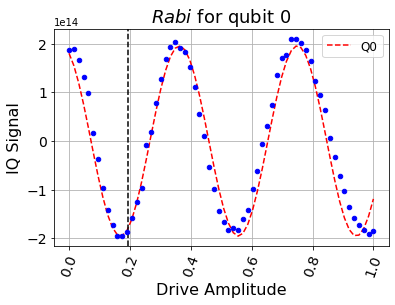

In [61]:
job_results = rabi_job.result()
result_data = [job_results.get_memory(i)[qubit]*SCALE for i in range(num_exps)]
rabi_fit = RabiFitter(job_results, xdata, [qubit], fit_p0 = [1.5e14, 2, 0, 0])

# get the pi amplitude
pi_amp = rabi_fit.pi_amplitude(0)

# plot
rabi_fit.plot(0)
print('Pi Amp: %f'%pi_amp)


In [62]:
pi_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_01')

In [63]:
with pulse.build(backend, name='x_01') as x_01:
    pulse.play(pi_pulse_01, pulse.drive_channel(0))

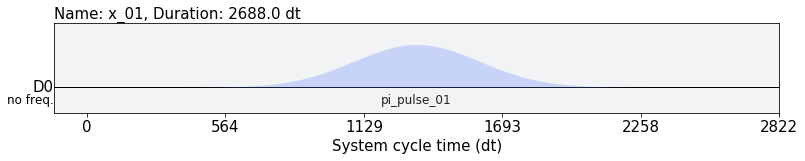

In [67]:
x_01.draw()

In [65]:
# ground state reference point
with pulse.build(backend=backend) as gs:
    with pulse.align_sequential():
        pulse.measure(0)

# excited state reference point
with pulse.build(backend=backend) as es:
    with pulse.align_sequential():
        pulse.play(pi_pulse_01, pulse.DriveChannel(0))
        pulse.measure(0)

schedules = [gs, es]
frequencies = np.linspace(-0.36e9, -0.32e9, 51)

for freq in frequencies:
    with pulse.build(backend=backend) as spec:
        with pulse.align_sequential():
            pulse.play(pi_pulse_01, pulse.DriveChannel(0))
            pulse.shift_frequency(freq, pulse.DriveChannel(0))
            pulse.play(pi_pulse_01, pulse.DriveChannel(0))
            pulse.measure(0)
        
    schedules.append(spec)

In [68]:
job = backend.run(schedules, meas_level=1)

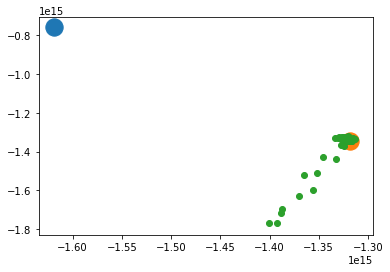

In [73]:
result = job.result()

signal = []
for idx in range(len(frequencies)+2):
    signal.append(result.get_memory(idx)[0])
    
plt.scatter(np.real(signal[0]), np.imag(signal[0]), label='Ground state',s=300)
plt.scatter(np.real(signal[1]), np.imag(signal[1]), label='1st excited state',s=300)
plt.scatter(np.real(signal[2:]), np.imag(signal[2:]), label='spectroscopy')

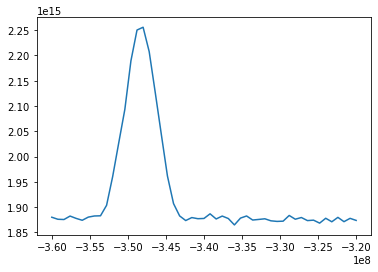

In [72]:
plt.plot(frequencies,np.abs(signal[2:]))

In [120]:
def match_sinc2(X,fs,boolPlot=True):
    
    #initial parameters
    B = np.min(X)
    fc = fs[np.argmax(X)]
    A = np.max(X) - B
    X_norm = (X - B)/A
    x_mean = np.mean(X_norm)
    df = x_mean*(np.max(fs)-np.min(fs))/np.pi/3
    
    #fit
    (params, X_model) =fit_function(fs,X,lambda f, fc, df, A, B: A*np.sinc((f-fc)/df)**2+B,[fc, df, A, B])
    
    if boolPlot == True:
        plt.scatter(fs,X,c='k')
        plt.plot(fs,X_model,c='b')
    
    return params

array([-3.48309362e+08, -5.76588696e+06,  3.77770866e+00,  1.87265460e+01])

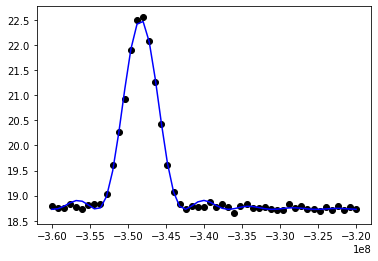

In [121]:
match_sinc2(X,frequencies)

In [86]:
X = np.abs(signal[2:])*SCALE

In [104]:
n = np.min(X)
fm = frequencies[np.argmax(X)]
a = np.max(X)-np.min(X)
X_norm = (X - n)/a
m = np.mean(X_norm)
df = m/np.pi*(frequencies[-1]-frequencies[0])

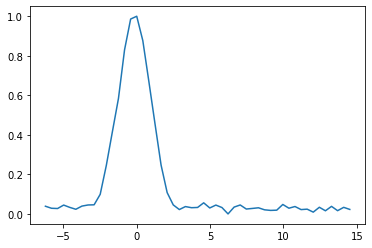

In [109]:
plt.plot((frequencies-fm)/df,X_norm)

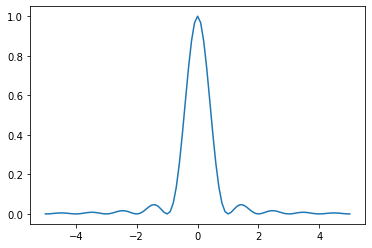

In [93]:
t=np.linspace(-5,5,101)
plt.plot(t,np.sinc(t)**2)

In [111]:
 (params, X_model) =fit_function(frequencies,
              X,
              lambda x, fc, df, A, B: A*np.sinc((x-fc)/df)**2+B,
              [fm, df, a, n])

In [112]:
params

array([-3.48309361e+08,  5.76588077e+06,  3.77771019e+00,  1.87265464e+01])

In [113]:
[fm, df, a, n]

[-348000000.0, 1928695.6819931122, 3.909206785393799, 18.64950923963192]

In [119]:
1928695/5765880

0.33450141175327963

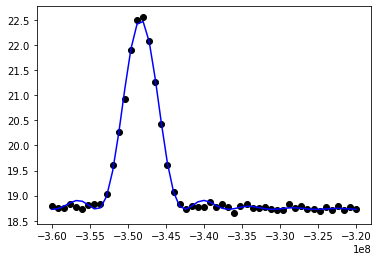

In [116]:
plt.scatter(frequencies,X,c='k')
plt.plot(frequencies,X_model,c='b')

In [118]:
params[0]+calib_qubit_freq

4623348141.267609

In [90]:
print(signal[0])
print(signal[1])

(-1619198644060160-759800652627968j)
(-1318028423725056-1342887828652032j)


In [66]:
pi_pulse_01.parameters

{}

In [82]:
config = backend.configuration()

In [84]:
print(config.to_dict())

{'backend_name': 'ibmq_armonk', 'backend_version': '2.4.13', 'n_qubits': 1, 'basis_gates': ['id', 'rz', 'sx', 'x'], 'gates': [{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0]]}, {'name': 'rz', 'parameters': ['theta'], 'qasm_def': 'gate rz(theta) q { U(0, 0, theta) q; }', 'coupling_map': [[0]]}, {'name': 'sx', 'parameters': [], 'qasm_def': 'gate sx q { U(pi/2, 3*pi/2, pi/2) q; }', 'coupling_map': [[0]]}, {'name': 'x', 'parameters': [], 'qasm_def': 'gate x q { U(pi, 0, pi) q; }', 'coupling_map': [[0]]}], 'local': False, 'simulator': False, 'conditional': False, 'open_pulse': True, 'memory': True, 'max_shots': 8192, 'coupling_map': None, 'dynamic_reprate_enabled': False, 'supported_instructions': ['rz', 'id', 'u2', 'delay', 'setf', 'shiftf', 'x', 'u1', 'play', 'u3', 'measure', 'acquire', 'sx'], 'max_experiments': 75, 'sample_name': 'family: Canary, revision: 1.2', 'n_registers': 1, 'credits_required': True, 'online_date': datetime.datetime(2

In [96]:
backend = provider.get_backend('ibmq_armonk')

In [22]:
backend_defaults = backend.defaults()

In [23]:
print(backend_defaults.to_dict())

{'qubit_freq_est': [4.97164897272186], 'meas_freq_est': [6.993370669000001], 'buffer': 0, 'pulse_library': [{'name': 'QId_d0', 'samples': [0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0

In [26]:
print(backend_defaults.cmd_def[0])

In [39]:
backend_defaults.cmd_def[6].to_dict()

{'name': 'u3',
 'qubits': [0],
 'sequence': [{'name': 'fc', 't0': 0, 'ch': 'd0', 'phase': '-(P2)'},
  {'name': 'parametric_pulse',
   't0': 0,
   'ch': 'd0',
   'label': 'X90p_d0',
   'pulse_shape': 'drag',
   'parameters': {'amp': (0.37062823536005807-0.07692462761912743j),
    'beta': -1.2917849688477199,
    'duration': 320,
    'sigma': 80}},
  {'name': 'fc', 't0': 320, 'ch': 'd0', 'phase': '-(P0)'},
  {'name': 'parametric_pulse',
   't0': 320,
   'ch': 'd0',
   'label': 'X90m_d0',
   'pulse_shape': 'drag',
   'parameters': {'amp': (-0.370628235360058+0.07692462761912752j),
    'beta': -1.2917849688477199,
    'duration': 320,
    'sigma': 80}},
  {'name': 'fc', 't0': 640, 'ch': 'd0', 'phase': '-(P1)'}]}

In [31]:
a

{'name': 'id',
 'qubits': [0],
 'sequence': [{'name': 'QId_d0', 't0': 0, 'ch': 'd0'}]}

In [99]:
backend_defaults.qubit_freq_est=calib_qubit_freq/1e9

In [100]:
print(backend_defaults.to_dict())

TypeError: 'numpy.float64' object is not iterable